# Introduction

## Overview of the Problem

Satellite plane detection is a critical task in various applications such as surveillance, environmental monitoring, and spatial mapping. The ability to accurately identify satellite planes from images can greatly enhance the efficiency and accuracy of satellite data interpretation, which is crucial for decision-making processess.

## Objective of the Project

The primary goal of this project is to develop a robust model that can detect satellite planes with high accuracy while minimizing false positives. By leveraging the power of Convolutional Neural Networks (CNNs), this project aims to refine image-based detection techniques to achieve superior performance in recognizing satellite planes from complex backgrounds and under varying conditions.

## Brief Overview of CNNs

Convolutional Neural Networks (CNNs) are a category of deep neural networks that are particularly powerful for tasks involving image recognition and classification. CNNs are designed to automatically and adaptively learn spatial hierarchies of features through backpropagation. This capability makes them exceptionally suitable for computer vision tasks, including the detection of objects within larger images, such as satellite planes in satellite imagery. The use of CNNs in this project is predicated on their success in similar applications, where they have consistently outperformed traditional machine learning approaches.


In [2]:
import cv2
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from glob import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.patches as patches

## Image Preprocessing

Preprocessing the images is a critical step to ensure that our Convolutional Neural Network (CNN) can effectively learn from the data. The preprocessing steps performed include:

1. **Reading the Images**: We start by looping over each png file in the specified directory. Each image represents a satellite photograph that may or may not contain a plane.

2. **Color Conversion**: By default, OpenCV reads images in BGR format. However, our CNN will perform better if the images are in RGB format.

3. **Normalization**: To facilitate faster convergence during training, we normalize the pixel values of each image.

Each preprocessed image is stored in a list, which will later be converted into a numpy array for numerical computation. This array forms the input to our CNN, enabling it to learn to distinguish between images with and without satellite planes.


In [3]:
# Assuming basepath is correctly set to point to the directory containing the images
basepath = "./data/planesnet/planesnet/"

# Read and process images in one go using a list comprehension
images = [cv2.cvtColor(cv2.imread(os.path.join(basepath, f)), cv2.COLOR_BGR2RGB) / 255.0 for f in os.listdir(basepath) if f.endswith('.png')]
labels = [int(f[0]) for f in os.listdir(basepath) if f.endswith('.png')]

# Convert lists to numpy arrays
images = np.array(images, dtype=np.float32)
labels = np.array(labels, dtype=np.int64)

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_validation = to_categorical(y_validation, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_validation.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")



Training set: 22400 images
Validation set: 6432 images
Test set: 3168 images


## Neural Network Architecture

The architecture of the CNN is composed of multiple convolutional layers followed by dense layers, each serving specific purposes in the image classification task:

### Convolutional Layers
- **Feature Extraction**: The network starts with several convolutional layers (Conv2D). These layers are responsible for extracting a hierarchy of features from the input images. The first layer captures basic patterns such as edges and textures. The other layers combine these initial features into more complex structures, such as parts of planes or entire objects within the satellite images.
- **Spatial Hierarchy and Local Connectivity**: Each convolutional layer processes part of the image using filters, maintaining spatial hierarchies and capturing local feature interactions. This approach allows the model to recognize patterns efficiently across different parts of the image.

### Activation Layers (LeakyReLU)
- **Non-linearity**: We use LeakyReLU activations to introduce non-linearity into the network, allowing it to learn more complex decision boundaries.

### Pooling Layers
- **Dimensionality Reduction**: MaxPooling layers reduce the dimensionality of the feature maps, decreasing the computational load and the number of parameters. This also helps in making the detection features more robust to variations in the image, such as changes in scale and orientation.

### Dropout and Batch Normalization
- **Regularization and Normalization**: Dropout layers randomly deactivate certain neurons during training, helping to prevent overfitting by ensuring that the network remains generalizable. Batch normalization layers normalize the outputs of previous layers, speeding up training and contributing to overall network stability.

### Dense Layers
- **Classification**: After feature extraction and flattening, the network transitions to dense layers, which synthesize the features extracted by convolutional layers to make final predictions. These fully connected layers integrate learned features, leading to effective classification.
- **Output Layer**: The final dense layer uses a softmax activation function to output probabilities for each class (plane or no plane), providing the basis for our classification decision.

In [4]:
# Setup the CNN
model = Sequential()
n_classes = 2

model.add(Conv2D(32, (3, 3), activation='linear', input_shape = (20, 20, 3), padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(256, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Dense(64, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Dense(n_classes, activation='softmax'))

C:\Users\JT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\JT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


## Model Configuration and Training

To prepare the model for detecting satellite planes, I set up a detailed training configuration, which includes compiling the model, setting checkpoints, and initiating the training process. Here’s how each component contributes to the model's training:

### Model Compilation
- **Loss Function**: We use binary_crossentropy for our loss function, which is ideal for binary classification tasks.
- **Optimizer**: The adam optimizer is chosen for its efficiency in handling sparse gradients and its adaptive learning rate capabilities.

### Checkpoints
- **ModelCheckpoint**: To ensure the best version of the model is captured during training, we implement a checkpoint strategy. This saves the model weights to a file ('plane_detection.keras') only when there is an improvement in validation accuracy (val_accuracy), which helps in avoiding overfitting and losing a potentially good model during the training process.

### Model Training
- **Training Execution**: The model is trained using the`model.fit() function, where I specify:
  - **Batch Size**: Set to 16.
  - **Epochs**: Training the model for 40 epochs.
  - **Validation Data**: The model's performance is regularly evaluated against a separate validation dataset, which helps in monitoring for overfitting.
  - **Callbacks**: The checkpoint strategy is included in the callbacks to ensure the model is saved based on the performance on the validation dataset.


In [5]:
# Run the CNN Epochs
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
checkpoint = ModelCheckpoint("plane_detection.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(X_train, y_train, batch_size=16, epochs=40, verbose=1, validation_data=(X_validation, y_validation), callbacks=[checkpoint])

Epoch 1/40
1398/1400 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7959 - loss: 0.4512
Epoch 1: val_accuracy improved from -inf to 0.75840, saving model to plane_detection.keras
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7960 - loss: 0.4509 - val_accuracy: 0.7584 - val_loss: 0.4683
Epoch 2/40
1397/1400 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9095 - loss: 0.2252
Epoch 2: val_accuracy improved from 0.75840 to 0.94481, saving model to plane_detection.keras
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9095 - loss: 0.2252 - val_accuracy: 0.9448 - val_loss: 0.1504
Epoch 3/40
1399/1400 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9212 - loss: 0.1989
Epoch 3: val_accuracy did not improve from 0.94481
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9212 - loss: 0.1989 - val_accuracy: 0.9199 - val_loss: 0.1943
Epoch 4/40
1395/1400 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9371 - loss: 0.1702
Epoch 4: val_accuracy did not improve from 0.94481
1

## Model Evaluation

After training, I evaluated the performance of our model using the test dataset, which has not been used during the model's training phase. This step helps us understand how well our model is likely to perform on completely unseen data.

### Evaluation Process
- **Model Testing**: We use the model.evaluate function, providing it with the test datasets.

### Results Reporting
- **Loss and Accuracy**:
  - Test Loss: A value of .039 is considered very good for image classification.
  - Test Accuracy: A value of .988 is considered very good as well.

The results from this evaluation give us valuable insights into the model’s performance and its capability to handle data it has not seen before.


In [25]:
# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9870 - loss: 0.0379
Test Loss: 0.039507780224084854
Test Accuracy: 0.9870581030845642


## Analysis of Model Performance

The graphs above provide a visual comparison of the Training and Validation Accuracy and Loss over the epochs. As you can see as we run more epochs, the benchmark from the training accuracy gets more and more accurate.

- **Accuracy Graph**: A close match between the training and validation accuracies suggests that the model generalizes well to new, unseen data.
- **Loss Graph**: Like the Accuracy Graph, the close match between the training and validation accuracies suggests that the model generalizes well to new, unseen data.

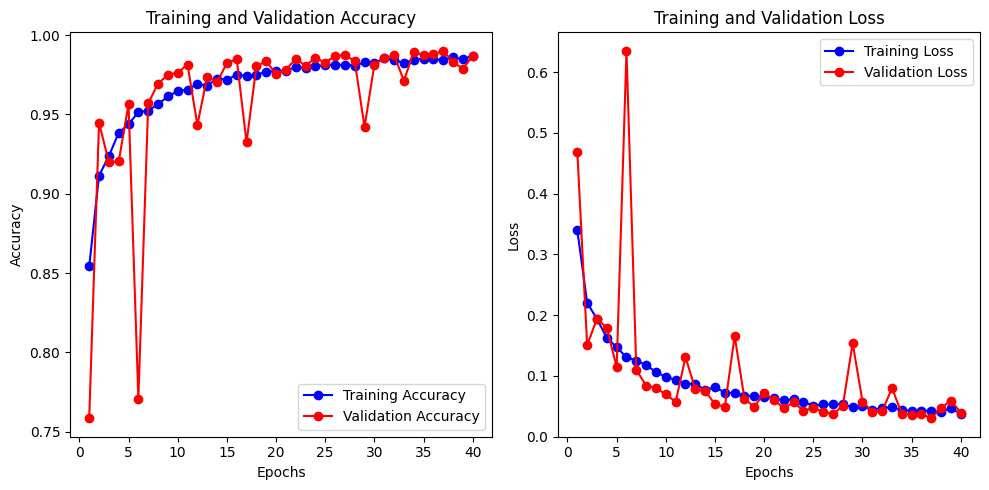

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Model Prediction and Evaluation

This section outlines the process of making predictions with the model and evaluating its accuracy:

1. **Predictions**: The model predicts classes for the test dataset X_test.

2. **True Labels**: Extract actual class labels from y_test, which are assumed to be one-hot encoded.

3. **Accuracy Assessment**:
   - The loop compares each predicted class with the actual class, categorizing them as correct or incorrect.

In [27]:
# Obtain predictions
predicted_class = model.predict(X_test)
predicted_class_probability = np.max(predicted_class, axis=1)*100
predicted_class = np.argmax(predicted_class, axis=1)
true_class = np.argmax(y_test, axis=1)

correct = []
incorrect = []

for i in range(len(predicted_class)):
    if predicted_class[i] == true_class[i]:
        correct.append(i)
    else:
        incorrect.append(i)

print('Correct predictions: ', len(correct))        
print('Incorrect predictions: ', len(incorrect))  

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Correct predictions:  3127
Incorrect predictions:  41


## Confusion Matrix Visualization

This section of the code generates and displays a confusion matrix for the model's predictions:

- **Matrix Creation**: computes the confusion matrix comparing true and predicted class labels.
- **Visualization**: Uses seaborn's heatmap function to plot the confusion matrix.

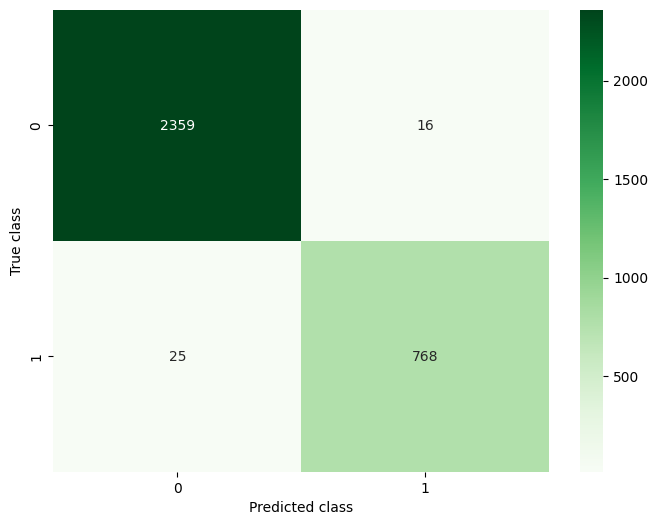

In [29]:
cm = confusion_matrix(true_class, predicted_class)
plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".0f", cmap='Greens')
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.show()

## Scene Processing and Prediction Visualization

This final code segment processes an image scene for object detection and visualizes the results:

- **Image Loading**: The script loads a specific image from a directory using cv2.imread, and it is converted from BGR to RGB color space for accurate color representation in matplotlib.

- **Sliding Window Detection**:
  - A sliding window approach is implemented to inspect sections of the image 20x20 pixels in strides of 5 pixels.
  - Each section is evaluated by the model to predict whether it contains the target object where 1 represents presence of a plane.

- **Visualization**:
  - If a target is detected in a window, a red rectangle is drawn on the image at the corresponding location.

Step 0 of 26
Step 1 of 26
Step 2 of 26
Step 3 of 26
Step 4 of 26
Step 5 of 26
Step 6 of 26
Step 7 of 26
Step 8 of 26
Step 9 of 26
Step 10 of 26
Step 11 of 26
Step 12 of 26
Step 13 of 26
Step 14 of 26
Step 15 of 26
Step 16 of 26
Step 17 of 26
Step 18 of 26
Step 19 of 26
Step 20 of 26
Step 21 of 26
Step 22 of 26
Step 23 of 26
Step 24 of 26
Step 25 of 26
Step 26 of 26


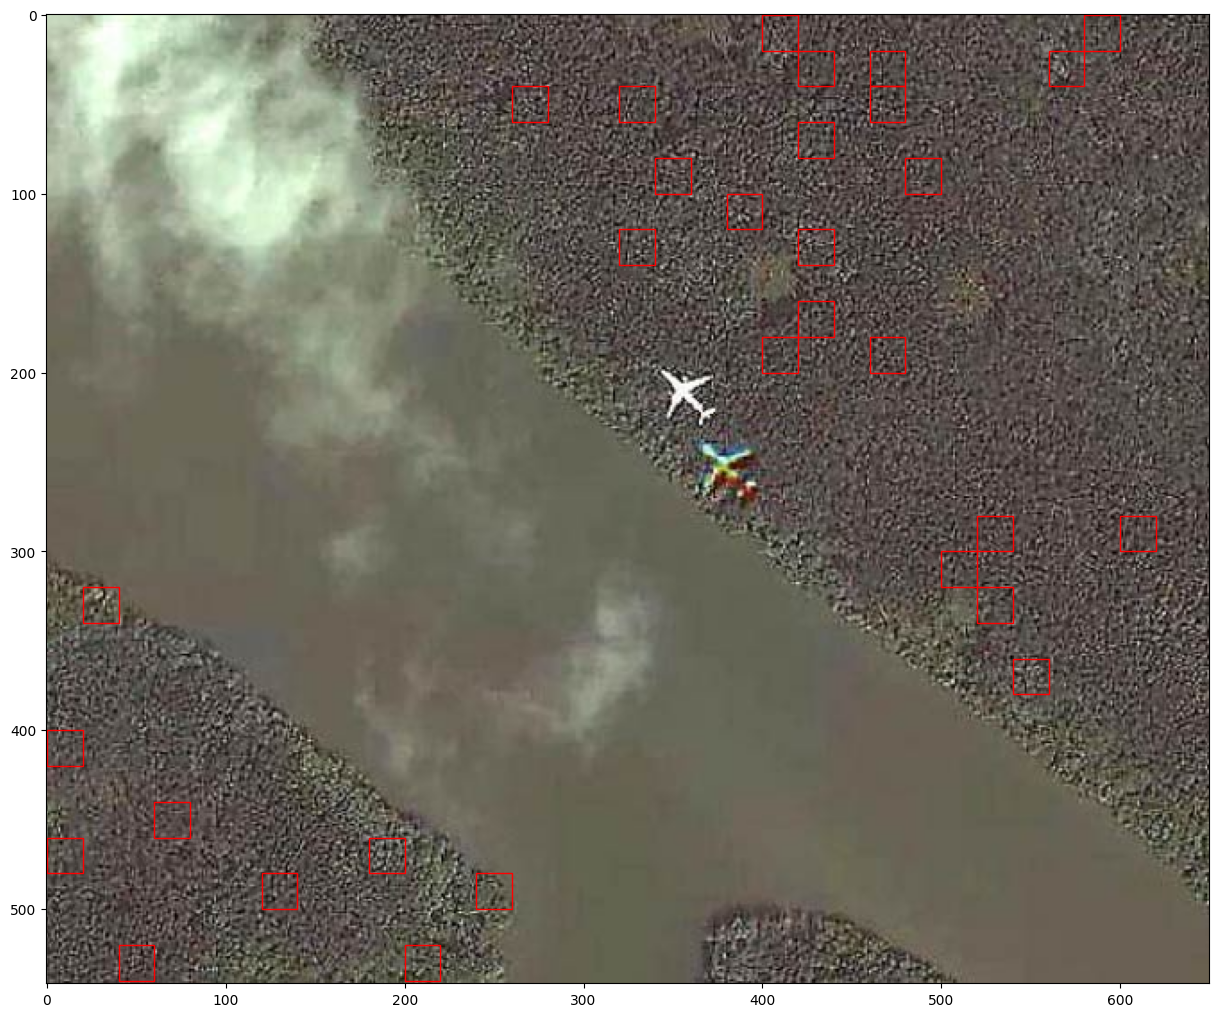

: 

In [31]:
# Load and show scene
basepath = "./data/scenes/scenes"

scene_list = glob(os.path.join(basepath, "*5*"))
scene_file = scene_list[0]

img = cv2.imread(scene_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
height, width, _ = img.shape

plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 1, 1)
ax.imshow(img)

stride = 20
for h in range(0, height-20, stride):
    print("Step", int(h/stride), "of", int((height-20)/stride))
    
    for w in range(0, width-20, stride):  
        img_box = []
        img_box.append(img[h:h+20, w:w+20])
        img_box = np.array(img_box, dtype=np.int64)
        prediction = model.predict(img_box, verbose=False)
        prediction = np.argmax(prediction)
        
        if prediction == 1:
            ax.add_patch(patches.Rectangle((w, h), 20, 20, edgecolor='r', facecolor='none'))
            
plt.show()

## Final Project Summary and Reflections

### Project Overview
The project aimed to develop a neural network for detecting planes in satellite images. Initial attempts involved using a custom CNN designed to classify small patches of images (20x20 pixels) to determine whether they contained a plane.

### Challenges Faced

1. **Image Size and Model Compatibility**:
   - The original approach using a custom CNN trained on 20x20 pixel images faced limitations due to the small image size, which is not typical for most pre-trained models.
   - Attempts to use a pre-trained ResNet50 model revealed issues since ResNet50 expects larger input sizes (224x224 pixels), leading to potential loss of detail when resizing small images.

2. **Model Choice and Efficacy**:
   - Initially considered using ResNet50, a model not optimized for the detection tasks as it is typically used for classification tasks.
   - Transitioned to exploring object detection models like YOLO and Faster R-CNN, which are more suited for spatially locating multiple objects within larger images.

3. **Sliding Window Technique**:
   - Initially employed a sliding window technique to manually scan and predict parts of images, which was computationally inefficient and less effective for capturing context due to isolated evaluation of image patches.

### Solutions and Adaptations

1. **Adapting to Pre-trained Models**:
   - Explored using pre-trained models like YOLO and Faster R-CNN, which are better suited for detecting multiple objects and can handle variable input sizes more effectively.
   - Learned about configuring and utilizing models from TensorFlow Model Zoo and PyTorch’s torchvision for state-of-the-art object detection capabilities.

2. **Resizing Strategy**:
   - Considered resizing strategies and their impacts, acknowledging that resizing very small images to fit pre-trained model requirements could lead to significant quality loss or distortion.

3. **Understanding Object Detection Dynamics**:
   - Gained insights into different architectures and their suitability for certain tasks, appreciating the distinction between image classification and object detection.

### What I Learned

- **Model Suitability**: Gained a deeper understanding of choosing the right model for the right task, especially distinguishing between use cases for image classification vs. object detection.
- **Pre-trained Models**: Learned how to leverage pre-trained models for complex tasks like object detection and the adjustments needed to tailor them to specific datasets and goals.
- **Technical Skills**: Enhanced technical skills in handling image data, configuring neural networks, and using advanced frameworks like TensorFlow and PyTorch.
- **Problem-Solving**: Developed problem-solving skills in adapting models to data-specific challenges, such as dealing with small image sizes in machine learning applications.

### Conclusion
This project not only enhanced my technical prowess in machine learning and deep learning but also sharpened my ability to critically analyze and adapt to the constraints posed by real-world data scenarios. The transition from a simplistic approach to adopting sophisticated pre-trained models marked significant growth in my approach to machine learning tasks.



https://www.kaggle.com/code/pavansanagapati/a-simple-cnn-model-beginner-guide (dataset source)

https://www.simplilearn.com/tutorials/deep-learning-tutorial/convolutional-neural-network (More information about CNN's)

https://www.geeksforgeeks.org/adam-optimizer/# (learning about adam optimizer)

https://youtu.be/jztwpsIzEGc (CNN Tutorial for building the CNN)

https://www.perplexity.ai/ (Web scraping for resources)
